# compare_accuracy.ipynb
This notebook is used to compare the accuracy and simulation times as various parameters are varied.
First, a reference network is simulated with high precision. This high precision comes from:
1. Cubic spline interpolation for the buffer values.
2. A minimum buffer size = 20.
3. Use of the `odeint` solver with `rtol` = 1e-5, `atol` = 1e-5.
4. A small `min_delay` (minimum delay) value (0.05).

Each of these four factors will be altered individually. For each variation, the maximum difference in the unit activities with respect to the high-precision simulation will be reported, along with simulation time. In addition, variations for factors 2 and 3 will be run for flat networks.

## initial setup
Before running this simulation, the code in `units.py` was modified so that the `unit.get_act` method had the contents:

    return self.interpolator(time)
    
Moreover, in `unit.__init__` there should be a line:

    self.using_interp1d = True
    
Configuration of `interp1d` is in `unit.upd_interpolator`, and was set as:
    
    self.interpolator = interp1d(self.times, self.buffer, kind='cubic',
                                 bounds_error=False, copy=False,
                                 fill_value="extrapolate", assume_sorted=True)
                                
The simulated network consists of an excitatory and an inhibitory population, called `e` and `i` respectively. Each population consists of 50 sigmoidal units, arranged in a 5x10 grid. Connections are made randomly, so that each excitatory unit sends projections to 10 other excitatory units (with delay 0.2), and to 15 inhibitory units (with delay 0.5). Each inhibitory unit sends projections to 10 excitatory units with delay 0.5.

The simulation starts from random initial parameters, and lasts for 10 seconds. After 5 seconds a step-like input is provided half of the excitatory units, and this input is maintained until the end of the simulation.

In [1]:
%cd ..
from ei_net import *
import pickle
from scipy.interpolate import interp1d

/home/z/projects/draculab


In [6]:
def create_ref_net():
    """ Returns an ei_net with parameter dictionaries for the high-accuracy configuration. """
    ei = ei_net()
    # network dictionary
    ei.set_param('net_params', 'min_delay', 0.005)
    ei.set_param('net_params', 'min_buff_size', 40)
    ei.set_param('net_params', 'rtol', 1e-5)
    ei.set_param('net_params', 'atol', 1e-5)
    # geometry dictionaries
    ei.set_param('e_geom', 'rows', 5)
    ei.set_param('e_geom', 'columns', 10)
    ei.set_param('e_geom', 'jitter', 0.)
    ei.set_param('i_geom', 'rows', 5)
    ei.set_param('i_geom', 'columns', 10)
    ei.set_param('i_geom', 'jitter', 0.)
    ei.set_param('n', 'w_track', 5)
    # connection dictionaries
    ei.set_param('ee_conn', 'mask', {'circular': {'radius' : 5.}}) # large mask
    ei.set_param('ee_conn', 'kernel', 1.) # deterministic kernel
    ei.set_param('ee_conn', 'number_of_connections', 10)
    ei.set_param('ee_conn', 'delays', {'linear': {'c': 0.2, 'a':0.}})
    ei.set_param('ee_conn', 'weights', {'uniform': {'low': 0.5, 'high':0.5}})
        
    ei.set_param('ei_conn', 'mask', {'circular': {'radius' : 5.}})
    ei.set_param('ei_conn', 'kernel', 1.)
    ei.set_param('ei_conn', 'number_of_connections', 15)
    ei.set_param('ei_conn', 'delays', {'linear': {'c': 0.5, 'a':0.}})
    ei.set_param('ei_conn', 'weights', {'uniform': {'low': 0.2, 'high':0.2}})
        
    ei.set_param('ie_conn', 'mask', {'circular': {'radius' : 5.}})
    ei.set_param('ie_conn', 'kernel', 1.)
    ei.set_param('ie_conn', 'number_of_connections', 10)
    ei.set_param('ie_conn', 'delays', {'linear': {'c': 0.5, 'a':0.}})
    ei.set_param('ie_conn', 'weights', {'uniform': {'low': -0.4, 'high':-0.4}})
        
    ei.set_param('xe_conn', 'mask', {'circular': {'radius' : 5.}})
    ei.set_param('xe_conn', 'kernel', 1.)
    ei.set_param('xe_conn', 'number_of_connections', 25)
    ei.set_param('xe_conn', 'delays', {'linear': {'c': 0.1, 'a':0.}})
    ei.set_param('xe_conn', 'weights', {'uniform': {'low': 1., 'high':1.}})
        
    ei.set_param('ii_conn', 'number_of_connections', 0)
    ei.set_param('xi_conn', 'number_of_connections', 0)
        
    return ei
    

In [3]:
# Create and build the ei_net object
ref_net = create_ref_net()
ref_net.build()

# Create an input pattern for the ei_net.run method
def inp_pat(pres, rows, columns):
    return np.ones(rows*columns) if pres >= 2 else np.zeros(rows*columns)

# Run the ei_net object
n_pres = 4
pres_time = 1.
ref_net.run(n_pres, pres_time, set_inp_pat=inp_pat, flat=False)

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


KeyboardInterrupt: 

In [4]:
ref_data_file = open('ref_data.pkl', 'wb')
pickle.dump((ref_net.all_times, ref_net.all_activs), ref_data_file)
ref_data_file.close()

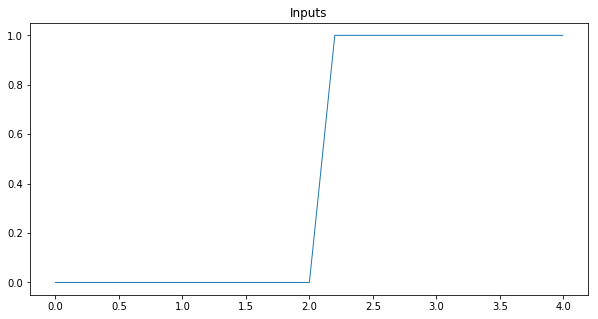

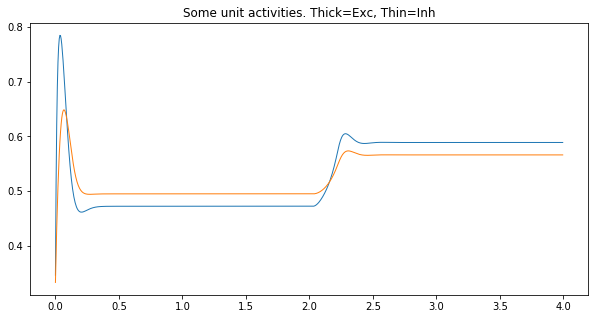

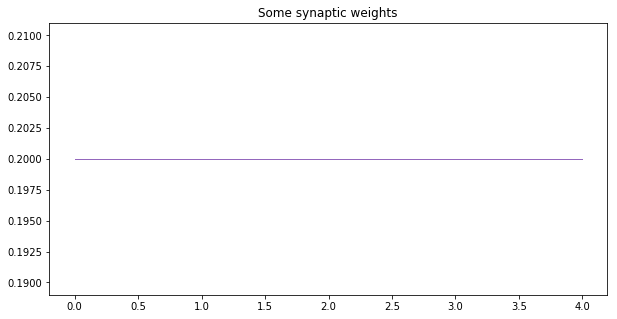

In [5]:
ref_net.basic_plot()

In [6]:
#%matplotlib qt5
ref_net.act_anim(ref_net.e, 0.6, slider=False)

## Variation 1: change interpolation method
**Variation 1a**: use `interp1d` with linear interpolation. All that is required is to change `kind` from `cubic` to `linear` in the `unit.upd_interpolator` method.

--- 

**Variation 1b**: use draculab's own linear interpolator.
In `unit.__init__` the variable `using_interp1d` was set to `False`, and in `unit.get_act` the content was:

    return cython_get_act3(time, self.times[0], self.time_bit, self.buff_size, self.buffer)
    
Before each variation, make sure to reset the kernel and run the first 2 cells.

In [7]:
# Create and build the ei_net object
var1_net = create_ref_net()
var1_net.build()

# Create an input pattern for the ei_net.run method
def inp_pat(pres, rows, columns):
    return np.ones(rows*columns) if pres >= 2 else np.zeros(rows*columns)

# Run the ei_net object
n_pres = 4
pres_time = 1.
var1_net.run(n_pres, pres_time, set_inp_pat=inp_pat, flat=False)
# Var1a time: 30.08 seconds
# Var1b time: 2.65 seconds

/home/z/projects/draculab/topology.py:435: UserWarning: Zero connections created with topo_connect
  warn('Zero connections created with topo_connect', UserWarning)


Presentation 0 took 3.92566180229187 seconds.
Presentation 1 took 3.792357921600342 seconds.
Presentation 2 took 3.55326247215271 seconds.
Presentation 3 took 3.758086919784546 seconds.
Total execution time is 15.030564069747925 seconds


In [8]:
# Compare with the reference data
opened_file = open('ref_data.pkl', 'rb')
read_times, read_activs = pickle.load(opened_file)
opened_file.close()
ref_sol = interp1d(read_times, read_activs, axis=1)
ref_values = ref_sol(var1_net.all_times)

diff = ref_values - var1_net.all_activs
print("Maximum difference in all values: %f " % (np.amax(np.abs(diff))))
print("Mean difference for all values: %f" %(np.mean(np.abs(diff))))

Maximum difference in all values: 0.015409 
Mean difference for all values: 0.000063


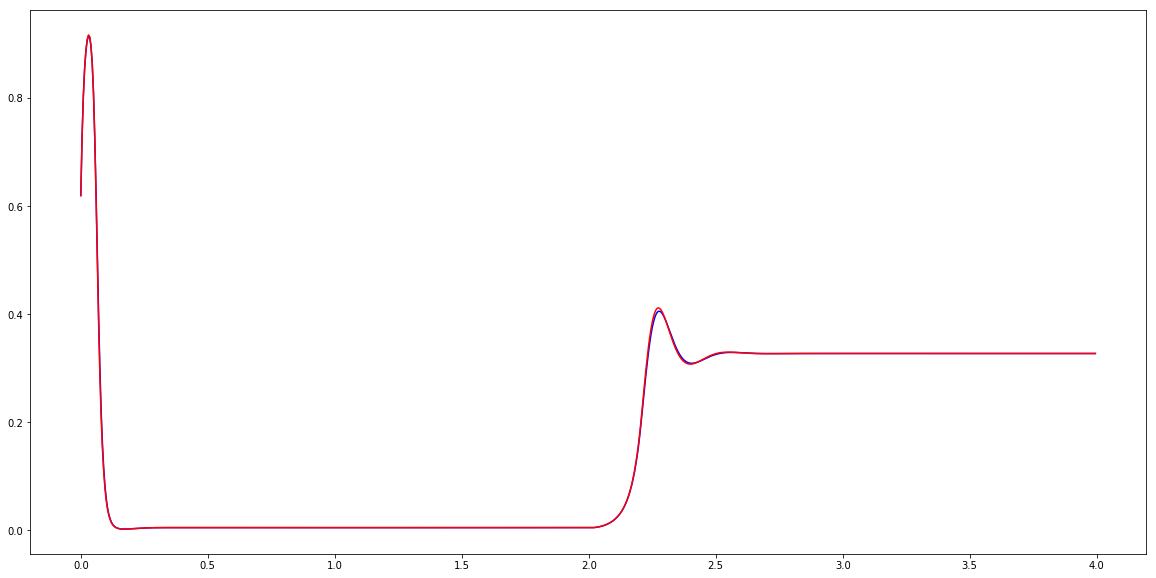

In [9]:
# Plotting the activity of the units with the maximum difference
unit, tpoint = np.unravel_index([np.argmax(np.abs(diff))], diff.shape)
fig = plt.figure(figsize=(20,10))
plt.plot(var1_net.all_times, var1_net.all_activs[unit[0]], 'b')
plt.plot(var1_net.all_times, ref_values[unit[0]], 'r')

In [15]:
var1_net.net.units[0].integ_meth

'odeint'

In [8]:
var1_net.net.units[13]

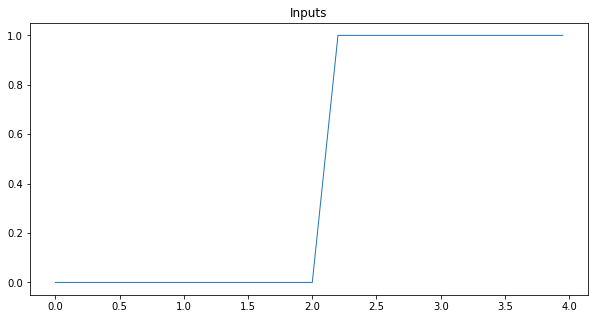

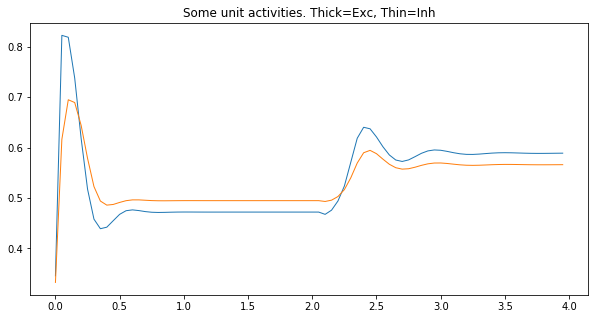

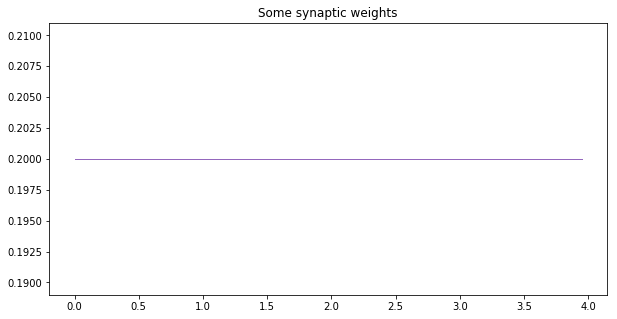

In [4]:
var1_net.basic_plot()

## Variation 2: change the minimum buffer size